In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import re
sns.set_theme(style="darkgrid")


In [184]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

In [185]:
print(train_df.shape, test_df.shape)

(1216553, 13) (5463, 12)


In [186]:
seoul_df = train_df[train_df['city'] == '서울특별시']
busan_df = train_df[train_df['city'] == '부산광역시']

In [187]:
print(len(seoul_df), len(busan_df), len(seoul_df) + len(busan_df))

742285 474268 1216553


In [188]:
train_df['dong'].nunique()

473

In [189]:
train_df['apt'].nunique()

10440

In [190]:
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt'])   

train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

# top 10 시공사 아파트 여부를 나타내는 컬럼 생성
train_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1

# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train_df['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'

# 아파트별 가격의 평균 내림차순 정렬
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

apt_dict = {}
for i, a in enumerate(list(apt_price.index)):
    train_df.loc[train_df['apt'] == a, 'apt'] = i # 라벨 인코딩
    apt_dict[i] = a
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', train_df['year_of_completion'].unique()[:5])
train_df['year_of_completion'] = train_df['year_of_completion'] - train_df['year_of_completion'].min()
print('변환후\n', train_df['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train_df['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train_df['transaction_year_month'] = le.fit_transform(train_df['transaction_year_month'])
# test는 다음과 같이 처리
print('train 변환후\n', train_df['transaction_year_month'].unique()[:5])

# 필요없는 열 제거
train_df = train_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

seoul_set = set(test_df.loc[test_df['city']=='서울특별시', 'dong'])
busan_set = set(test_df.loc[test_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

for d in same_dong:
    train_df.loc[(train_df['city']=='서울특별시') & (train_df['dong']==d), 'dong'] = '서울' + d
    train_df.loc[(train_df['city']=='부산광역시') & (train_df['dong']==d), 'dong'] = '부산' + d
    test_df.loc[(test_df['city']=='서울특별시') & (test_df['dong']==d), 'dong'] = '서울' + d
    test_df.loc[(test_df['city']=='부산광역시') & (test_df['dong']==d), 'dong'] = '부산' + d
    

seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)

# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
dong_dict = {}
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    train_df.loc[train_df['dong'] == d, 'dong'] = i
    test_df.loc[test_df['dong'] == d, 'dong'] = i
    dong_dict[i] = d
train_df.head()

# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', train_df['floor'].values[:5])
train_df['floor'] = train_df['floor'].map(lambda x: x+4)
test_df['floor'] = test_df['floor'].map(lambda x: x+1)
print('변환후\n', train_df['floor'].values[:5])

# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price'] = np.log1p(train_df['transaction_real_price'])

# 면적 로그 변환 후 원래 면적 따로 저장
train_df['log_area'] = np.log1p(train_df['exclusive_use_area'])

drop_col = ['transaction_id', 'apartment_id', 'apt_counts', 'transformed']

train_df['city'] = train_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test_df['city'] = test_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)

train_df.drop(drop_col, axis=1, inplace=True)

100%|██████████| 25/25 [00:00<00:00, 45.48it/s]


변환전
 apt
잠실      91273.525326
파크리오    88739.646736
자이      79838.112467
래미안     64184.531289
아이파크    63115.982726
Name: transaction_real_price, dtype: float64
변환후
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64
변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
train 변환후
 [0 1 2 3 4]
{'송정동', '중동', '부암동', '사직동'}
{'송정동', '중동', '부암동', '사직동'}
set()


100%|██████████| 477/477 [00:31<00:00, 15.15it/s]


변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


In [191]:
train_df['dong'] = train_df['dong'].astype('int64')
train_df['apt'] = train_df['apt'].astype('int64')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  int64  
 2   apt                     1216553 non-null  int64  
 3   exclusive_use_area      1216553 non-null  float64
 4   year_of_completion      1216553 non-null  int64  
 5   transaction_year_month  1216553 non-null  int64  
 6   floor                   1216553 non-null  int64  
 7   transaction_real_price  1216553 non-null  int64  
 8   top10                   1216553 non-null  int64  
 9   log_price               1216553 non-null  float64
 10  log_area                1216553 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 111.4 MB


In [192]:
train_df.head()

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area
0,1,138,23,84.82,41,0,6,37500,0,10.532123,4.452252
1,1,65,23,99.17,12,0,10,20000,0,9.903538,4.606869
2,1,65,23,84.74,46,0,10,38500,0,10.558439,4.451319
3,1,13,23,146.39,42,0,19,118000,0,11.678448,4.993082
4,1,13,23,194.43,43,0,7,120000,0,11.695255,5.275202


In [193]:
# dataframe sampling 1%
sample = train_df.sample(frac=5e-4, random_state=42)
print(sample.shape)

(608, 11)


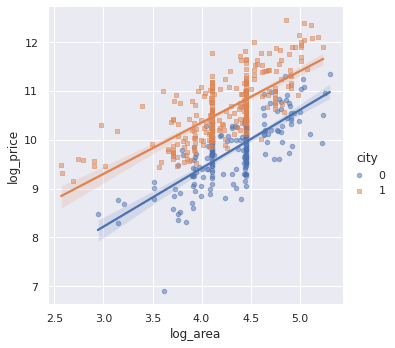

In [194]:
sns.lmplot(x='log_area', y='log_price', hue='city', data=sample, markers=['o', 's'], scatter_kws={'alpha':0.5, 's':20})
plt.show()

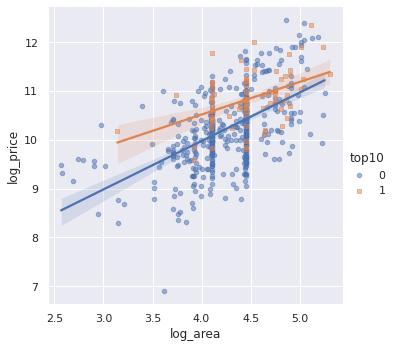

In [195]:
sns.lmplot(x='log_area', y='log_price', hue='top10', data=sample, markers=['o', 's'], scatter_kws={'alpha':0.5, 's':20})
plt.show()

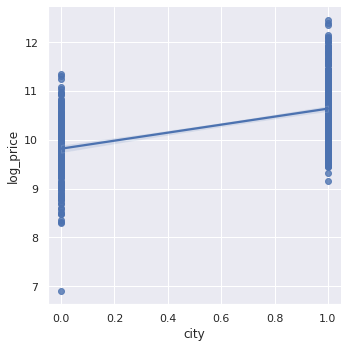

In [196]:
sns.lmplot(x='city', y='log_price', data=sample)
plt.show()

[]

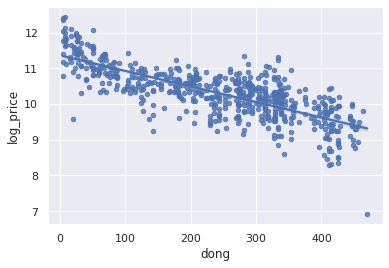

In [197]:
sns.regplot(x='dong', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

[]

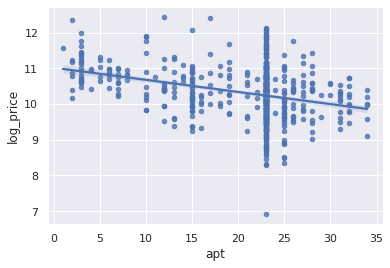

In [198]:
sns.regplot(x='apt', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

[]

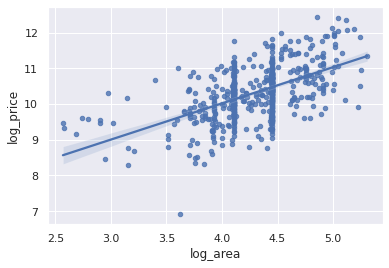

In [199]:
sns.regplot(x='log_area', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

[]

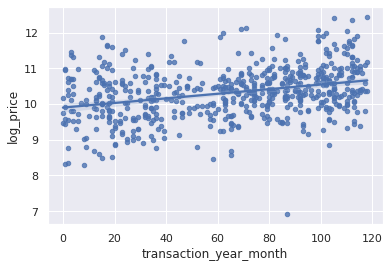

In [200]:
sns.regplot(x='transaction_year_month', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

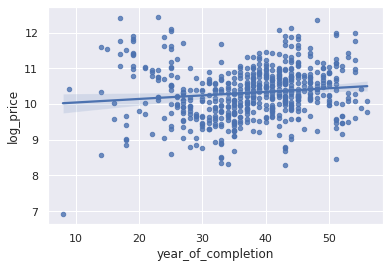

In [201]:
sns.regplot(x='year_of_completion', y='log_price', data=sample, scatter_kws={'s': 20})
plt.show()

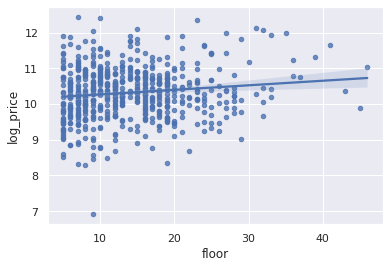

In [202]:
sns.regplot(x='floor', y='log_price', data=sample, scatter_kws={'s': 20})
plt.show()

In [203]:
params = {'max_depth': 12, 'learning_rate': 0.00997868692396887,
 'n_estimators': 2327, 'min_child_samples': 8, 'subsample': 0.48772098248194684}

cut = int(len(train_df) * 0.75)
tr = train_df.iloc[:cut]
te = train_df.iloc[cut:]
print(tr.shape, te.shape)

model = lgb.LGBMRegressor(**params)
model.fit(tr.drop('log_price', axis=1), tr['log_price'])
pred = model.predict(te.drop('log_price', axis=1))

(912414, 11) (304139, 11)


In [204]:
te['pred'] = np.expm1(pred)
te

/tmp/ipykernel_197856/365052255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te['pred'] = np.expm1(pred)


,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,pred
912414,0,329,31,59.7300,35,101,10,29000,0,10.275086,4.106438,28976.537360
912415,0,329,27,59.9900,37,101,16,21000,1,9.952325,4.110710,20976.276720
912416,0,329,31,84.9900,35,101,19,35800,0,10.485731,4.454231,35721.585974
912417,0,329,23,134.9900,35,101,7,40500,0,10.609082,4.912581,40396.099999
912418,0,329,14,59.9400,35,101,5,21600,0,9.980495,4.109890,21720.554353
...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,118,7,22000,0,9.998843,4.107993,21995.028054
1216549,0,305,23,84.9923,51,118,11,30750,0,10.333678,4.454258,30721.110021
1216550,0,305,23,84.9923,51,118,13,29500,0,10.292179,4.454258,29489.650060
1216551,0,305,10,101.7400,47,118,11,26700,1,10.192456,4.632202,26725.684165


In [205]:
train_df['dong_avg_price'] = train_df.groupby('dong')['transaction_real_price'].transform('mean')
train_df['apt_avg_price'] = train_df.groupby('apt')['transaction_real_price'].transform('mean')
train_df

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,dong_avg_price,apt_avg_price
0,1,138,23,84.8200,41,0,6,37500,0,10.532123,4.452252,45994.444444,34691.002032
1,1,65,23,99.1700,12,0,10,20000,0,9.903538,4.606869,61963.333333,34691.002032
2,1,65,23,84.7400,46,0,10,38500,0,10.558439,4.451319,61963.333333,34691.002032
3,1,13,23,146.3900,42,0,19,118000,0,11.678448,4.993082,107899.014778,34691.002032
4,1,13,23,194.4300,43,0,7,120000,0,11.695255,5.275202,107899.014778,34691.002032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,118,7,22000,0,9.998843,4.107993,27299.963804,34691.002032
1216549,0,305,23,84.9923,51,118,11,30750,0,10.333678,4.454258,27299.963804,34691.002032
1216550,0,305,23,84.9923,51,118,13,29500,0,10.292179,4.454258,27299.963804,34691.002032
1216551,0,305,10,101.7400,47,118,11,26700,1,10.192456,4.632202,27299.963804,48182.652143


In [211]:
import json
with open('apt_dict.json', 'w') as f:
    json.dump(apt_dict, f, indent=2, ensure_ascii=False)

with open('dong_dict.json', 'w') as f:
    json.dump(dong_dict, f, indent=2, ensure_ascii=False)

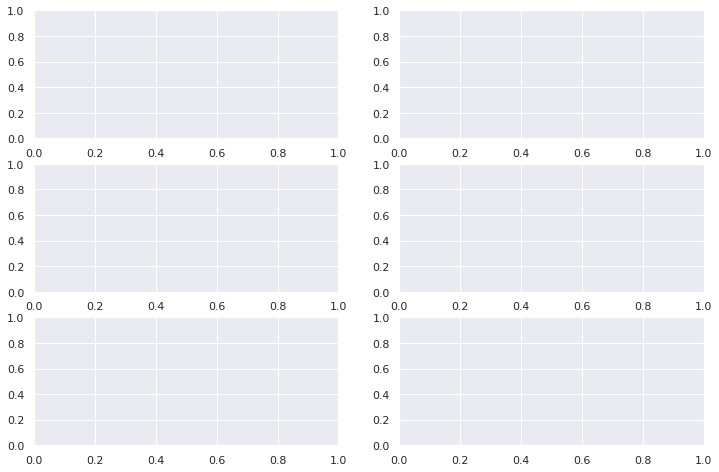

In [212]:
f, ax = plt.subplots(3,2,figsize=(12, 8) )


In [206]:
# 성능 비교
my = {'time': 3592, 'score': 0.2085}
wv_32_32 = {'time': 5029, 'score': 0.2252}
wv_256_256 = {'time': 12580, 'score': 0.2222}
wv_512_32 = {'time': 13802, 'score': 0.2197}
ft_32_32 = {'time': 5053, 'score': 0.2147}
ft_256_256 = {'time': 12417, 'score': 0.2088}
ft_512_32 = {'time': 13606, 'score': 0.2146}

In [207]:
d = {'time': [my['time'], wv_32_32['time'], wv_256_256['time'], wv_512_32['time'], ft_32_32['time'], ft_256_256['time'], ft_512_32['time']], 'score': [my['score'], wv_32_32['score'], wv_256_256['score'], wv_512_32['score'], ft_32_32['score'], ft_256_256['score'], ft_512_32['score']]}
score_df = pd.DataFrame(d)
score_df['model_name'] = ['encoding', 'wv_32_32', 'wv_256_256', 'wv_512_32', 'ft_32_32', 'ft_256_256', 'ft_512_32']
score_df['model_type'] = ['encoding', 'w2v', 'w2v', 'w2v', 'fasttext', 'fasttext', 'fasttext']
# change col order
score_df = score_df[['model_name', 'model_type', 'time', 'score']].sort_values(by='time')
score_df

,model_name,model_type,time,score
0,encoding,encoding,3592,0.2085
1,wv_32_32,w2v,5029,0.2252
4,ft_32_32,fasttext,5053,0.2147
5,ft_256_256,fasttext,12417,0.2088
2,wv_256_256,w2v,12580,0.2222
6,ft_512_32,fasttext,13606,0.2146
3,wv_512_32,w2v,13802,0.2197
